In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os       # to find absolute path for saver

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('MNIST/data', one_hot=True)

Extracting MNIST/data\train-images-idx3-ubyte.gz
Extracting MNIST/data\train-labels-idx1-ubyte.gz
Extracting MNIST/data\t10k-images-idx3-ubyte.gz
Extracting MNIST/data\t10k-labels-idx1-ubyte.gz


In [4]:
(train_data, validation_data, test_data) = (mnist.train, mnist.validation, mnist.test)

In [5]:
train_data.num_examples

55000

In [6]:
with tf.name_scope('Inputs') as scope:
    x = tf.placeholder(shape=[None, 784], dtype=tf.float32, name='images')
    x_image = tf.reshape(x, [-1, 28, 28, 1], name='2d_images')
    y_correct = tf.placeholder(shape=[None, 10], dtype=tf.float32, name='correct_output')

In [7]:
#sess = tf.Session()

In [8]:
#sess.run(tf.shape(x_image))

In [9]:
# first convolution
filter_conv1 = 32
W_conv1 = tf.Variable(tf.truncated_normal(shape=[6, 6, 1, filter_conv1], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.zeros([filter_conv1]), name="b_conv1")
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 2, 2, 1], padding='SAME') + b_conv1   # (None, 14, 14, filter_conv1)
h_conv1_relu = tf.nn.relu(h_conv1)

In [10]:
#sess.run(tf.shape(h_conv1))

In [11]:
#with tf.name_scope('First_pooling') as scope:
h_pool_1 = tf.nn.max_pool(h_conv1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 7, 7, filter_conv1)


In [12]:
#sess.run(tf.shape(h_pool_1))

In [13]:
# second convolution
filter_conv2 = 64
W_conv2 = tf.Variable(tf.truncated_normal(shape=[4, 4, filter_conv1, filter_conv2], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.zeros([filter_conv2]), name="b_conv2")
h_conv2 = tf.nn.conv2d(h_pool_1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2   # (None, 7, 7, filter_conv2)
h_conv2_relu = tf.nn.relu(h_conv2)

In [14]:
# second convolution
h_pool_2 = tf.nn.max_pool(h_conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 4, 4, filter_conv2)

In [15]:
# Fully Connected
neuron_1 = 4*4*filter_conv2
#neuron_1 = 7*7*filter_conv2
neuron_2 = neuron_1 // 2

In [16]:
# flatten
fc_input = tf.reshape(h_pool_2, [-1, neuron_1])


In [17]:
W_1 = tf.Variable(tf.truncated_normal([neuron_1, neuron_2]), name="W_1")
b_1 = tf.Variable(0.0, [neuron_2], name="b_1")
a_1 = tf.nn.relu(tf.matmul(fc_input, W_1) + b_1)

In [18]:
keep_prob = tf.placeholder(tf.float32)
a_1_drop = tf.nn.dropout(a_1, keep_prob)

In [19]:
W_2 = tf.Variable(tf.truncated_normal([neuron_2, 10]), name="W_2")
b_2 = tf.Variable(0.0, [10], name="b_2")
y = tf.matmul(a_1_drop, W_2) + b_2

In [20]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_correct, logits=y))

In [21]:
# Optimization
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_correct,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
sess = tf.InteractiveSession()
#saver = tf.train.Saver([W_conv1, b_conv1, W_conv2, b_conv2, W_1, b_1, W_2, b_2])
#saver = tf.train.Saver({v.op.name: v for v in [W_conv1, b_conv1, W_conv2, b_conv2, W_1, b_1, W_2, b_2]})
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
file_writer = tf.summary.FileWriter("CNN_baitap_2", sess.graph)
# create a summary for our cost and accuracy
tf.summary.scalar("cost_summary", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
# merge all summaries into a single operation which we can execute in a session 
summary_step = tf.summary.merge_all()


validation_size = 4000
for i in range(3001):
    batch_xs, batch_ys = mnist.train.next_batch(200)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_xs, y_correct: batch_ys , keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        valid_xs, valid_ys = mnist.validation.next_batch(validation_size)
        print("Accuracy validation: {}".format(accuracy.eval(
                feed_dict = {x: valid_xs, y_correct: valid_ys, keep_prob: 1.0 })))
    _, summary = sess.run([train_step, summary_step], 
            feed_dict={x: batch_xs, y_correct: batch_ys, keep_prob: 0.6})
    # logging
    file_writer.add_summary(summary, i)

print("Accuracy: {}".format(accuracy.eval(feed_dict = {x: mnist.test.images[:validation_size], 
                                               y_correct: mnist.test.labels[:validation_size], keep_prob: 1.0})))
print("Saving model")
saver.save(sess, os.path.join(os.getcwd(), 'CNN_baitap_2_model'), global_step=3000)
saved_W_conv1 = sess.run(W_conv1)      # save to verify session saver

step 0, training accuracy 0.115
Accuracy validation: 0.08500000834465027
step 1000, training accuracy 0.84
Accuracy validation: 0.8217501044273376
step 2000, training accuracy 0.865
Accuracy validation: 0.8530001044273376
step 3000, training accuracy 0.915
Accuracy validation: 0.9007501006126404
Accuracy: 0.8687500953674316
Saving model


In [23]:
sess.close()

## Restore

In [24]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('CNN_baitap_2_model-3000.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from D:\massp\tensorflow_tutorials\tutorials\tensorflow\CNN_baitap_2_model-3000


In [25]:
sess.run('W_conv1:0')

array([[[[ 0.00316854,  0.09024522,  0.06200399, ...,  0.09870239,
          -0.07136393,  0.17325082]],

        [[-0.13014147,  0.07260958,  0.01379364, ...,  0.12488105,
          -0.14258106, -0.14919622]],

        [[ 0.06968206, -0.06778286,  0.17368905, ..., -0.0186156 ,
           0.06669079,  0.02078193]],

        [[ 0.08613362,  0.032818  , -0.05582419, ...,  0.12412617,
           0.02151738,  0.14057951]],

        [[ 0.00252516, -0.01156457,  0.15557224, ..., -0.0774354 ,
          -0.04165656, -0.0869826 ]],

        [[-0.03394603, -0.01955202, -0.01802604, ...,  0.04389001,
           0.07652414, -0.13030523]]],


       [[[-0.06665552,  0.12217105,  0.01767361, ..., -0.12240701,
          -0.07917286, -0.06238475]],

        [[-0.16567555, -0.01519218, -0.00056305, ..., -0.00166772,
           0.03678939, -0.00675085]],

        [[-0.12866157,  0.01199562, -0.08739173, ..., -0.12302575,
          -0.0202344 ,  0.04342277]],

        [[ 0.05932493, -0.09734096, -0.07983

In [26]:
W_conv1_arr = sess.run('W_conv1:0')

In [27]:
W_conv1_arr.shape

(6, 6, 1, 32)

In [33]:
first = W_conv1_arr[:, :, :, 0].reshape((6, 6))
mid = W_conv1_arr[:, :, :, 15].reshape((6, 6))
last = W_conv1_arr[:, :, :, 31].reshape((6, 6))

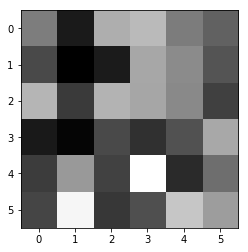

In [36]:
plt.imshow(first, cmap='gray')
plt.show()